In [6]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from bids import BIDSLayout
import mne_bids
#import settings
import json
#from coordinates_io import BIDS_coord
from sklearn import linear_model
import multiprocessing
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

In [3]:
out_path = '/home/icn/Documents/raw_out/raw_combined/'
out_path = 'sub_010_patient_concat.json'

In [ ]:
subject_id = '010'

In [7]:
with open('sub_010_patient_concat.json', 'r') as fp:
    dict_ch = json.load(fp)

In [8]:
dict_ch.keys()

dict_keys(['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'STN_RIGHT_3', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'STN_LEFT_3'])

In [15]:
dict_ch[list(dict_ch.keys())[0]].keys()

dict_keys(['data', 'true_movements', 'mov_ch', 'choords', 'res_MOV_RIGHT', 'res_MOV_LEFT'])

In [22]:
movements_channel =  [mov for mov in list(dict_ch[channels[0]].keys()) if mov.startswith('res_MOV')]

In [23]:
movements_channel

['res_MOV_RIGHT', 'res_MOV_LEFT']

In [25]:
dict_ch[channels[0]][movements_channel[0]]["R2"]

0.14347507915946361

In [26]:
dict_ch[channels[0]][movements_channel[0]]

{'R2': 0.14347507915946361,
 'weight_MOV_RIGHT': [-0.11921310360874146,
  -0.20942463787194535,
  -0.3025098198201777,
  -0.056103066432295866,
  -0.0657996399720697,
  0.3126802886699624,
  -0.19175371805518734,
  -0.6001575452538882]}

In [17]:
dict_ch[channels[0]]["choords"][0]

NameError: name 'channels' is not defined

In [31]:
#plot: run through all channels per Patient and plot the res vals +
# if STN is True: 
ind_ECOG = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("ECOG")]

In [32]:
ind_ECOG

[0, 1, 2, 3, 4, 5]

In [10]:
# setup plot where STN and ECOG is visible 
faces = io.loadmat('faces.mat')
Vertices = io.loadmat('Vertices.mat')
grid = io.loadmat('grid.mat')['grid']
stn_surf = io.loadmat('STN_surf.mat')

In [ ]:
def plot_STN_with_grid(x_grid, y_grid, coords_x, coords_y, val, clim_low, clim_high):
    plt.scatter(x_grid, y_grid, c='gray', s=0.25, alpha='0.5')
    plt.axis('off')
    plt.scatter(coords_x, coords_y, c = val, s = 30, alpha=1)
    cbar = plt.colorbar()
    plt.clim(clim_low, clim_high)
    cbar.remove()
    plt.axis('equal')

In [8]:
x_ = stn_surf['vertices'][::2,0]
y_ = stn_surf['vertices'][::2,1]

In [199]:
def get_movement_idx(ch, mov_channels, Contra=True):
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Contra is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx

In [200]:
def get_x_y_c(dict_ch, ind_, Contra=True):
    x_choord = np.zeros(len(ind_))
    y_choord = np.zeros(len(ind_))
    c_ = np.zeros(len(ind_))
    for idx, ind_ch in enumerate(ind_): 
        choord = np.squeeze(np.array(dict_ch[channels[ind_ch]]["choords"]))
        x_choord[idx] = choord[0]
        y_choord[idx] = choord[1]
        
        #wähle den contralateralen channel aus
        mov_channels = dict_ch[channels[ind_ch]]['mov_ch']
        
        mov_idx = get_movement_idx(channels[ind_ch], mov_channels, Contra)
        
        c_[idx] = dict_ch[channels[ind_ch]]["res_"+mov_channels[mov_idx]]["R2"]
    return x_choord, y_choord, c_

In [36]:
channels = list(dict_ch.keys())
ind_ECOG = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("ECOG")]
ind_STN = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("STN")]

In [38]:
x,y,c = get_x_y_c(dict_ch, ind_STN)

In [91]:
x_ecog = Vertices['Vertices'][::4,0]
y_ecog = Vertices['Vertices'][::4,1]
x_stn = stn_surf['vertices'][::2,0]
y_stn = stn_surf['vertices'][::2,1]

In [161]:
subject_id = []
for patient_test in range(17):
    if patient_test < 10:
        subject_id.append(str('00') + str(patient_test))
    else:
        subject_id.append(str('0') + str(patient_test))


In [164]:
for idx in range(16):
    if idx%4 == 0:
        print(idx)

0
4
8
12


FileNotFoundError: [Errno 2] No such file or directory: 'sub_0_patient_concat.json'

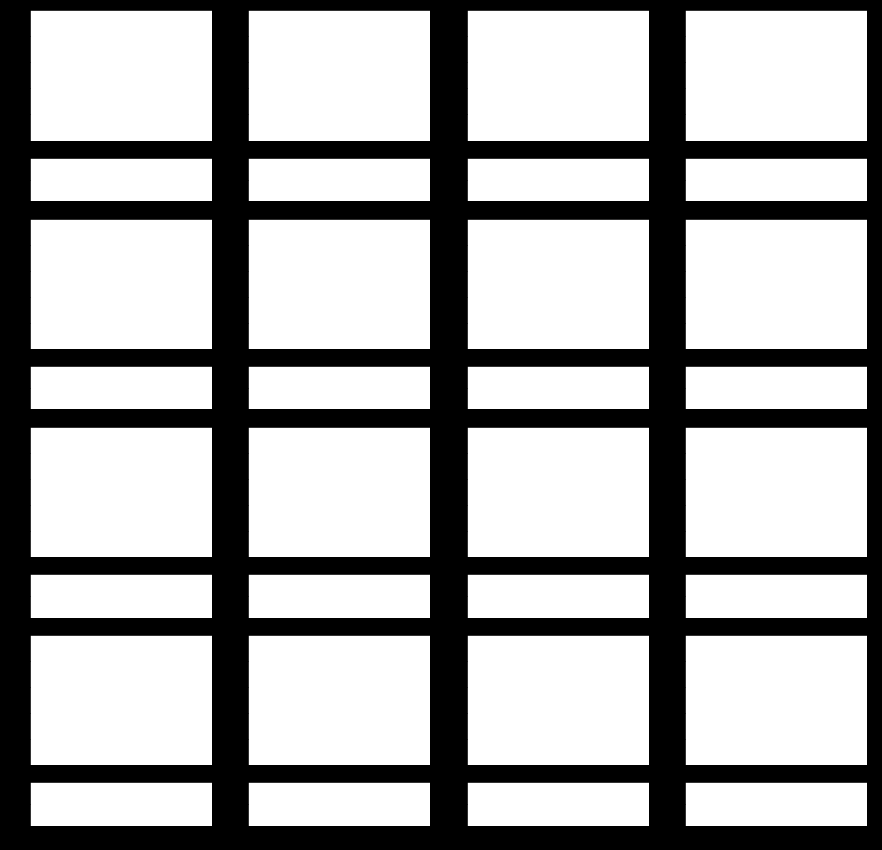

In [170]:
fig, axes = plt.subplots(8,4, facecolor=(0,0,0), gridspec_kw={'height_ratios': [3,1,3,1,3,1,3,1]}, figsize=(15,15))
x__ = 0
y__ = 0
for sub_idx, subject_id_ in enumerate(subject_id[-1]):
    
    with open('sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
        dict_ch = json.load(fp)
    channels = list(dict_ch.keys())
    ind_ECOG = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("ECOG")]
    ind_STN = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("STN")]


    axes[x__, y__].scatter(x_ecog, y_ecog, c="gray", s=0.25)
    axes[x__, y__].set_title('sub000'+str('\n con.             ips.'), color='white')
    x,y,c = get_x_y_c(dict_ch, ind_ECOG)
    axes[x__, y__].scatter(x, y, c=c, s=50)
    #ax.axes.set_axis_off()
    axes[x__, y__].axes.set_aspect('equal')
    axes[x__, y__].set_facecolor((0,0,0))

    axes[x__, y__+1].scatter(x_stn, y_stn, c="gray", s=0.25)
    x,y,c = get_x_y_c(dict_ch, ind_STN)
    axes[x__, y__+1].scatter(x, y, c=c, s=50)
    #ax1.axes.set_axis_off()
    axes[x__, y__+1].axes.set_aspect('equal')
    axes[x__, y__+1].set_facecolor((0,0,0))
    #plt.tight_layout()
    
    if idx%4 == 0:
        y__ += 2
        
    if x__ == 4:
        x__ = 0
    else:
        x__ +=1

In [193]:
### look at weights 
mov_channels = dict_ch[channels[0]]["mov_ch"]

In [192]:
mov_channels

['MOV_RIGHT', 'MOV_LEFT']

In [194]:
dict_ch[channels[0]]['res_'+mov_channels[0]]['weight_'+mov_channels[0]]

[0.1440842071067892,
 0.13794501376621138,
 -0.45103167084482026,
 -0.3756353088378953,
 1.2459724654871827,
 0.1117129016165456,
 -0.13039294258762804,
 0.09910339302633278]

In [236]:
def get_best(dict_ch, Con=True):
    channels = list(dict_ch.keys())
    acc_ = np.zeros(len(channels))
    mov_idx_ = np.zeros(len(channels))
    for ch_idx, ch  in enumerate(channels):
        mov_channels = dict_ch[channels[ch_idx]]["mov_ch"]
        mov_idx = get_movement_idx(channels[ch_idx], mov_channels, Con)
        acc_[ch_idx] = dict_ch[channels[ch_idx]]['res_'+mov_channels[mov_idx]]['R2']
        mov_idx_[ch_idx] = mov_idx
    best_ch_idx = np.argmax(acc_)
    mov_idx_best = int(mov_idx_[best_ch_idx])
    return channels[best_ch_idx], np.max(acc_), dict_ch[channels[best_ch_idx]]['res_'+mov_channels[mov_idx_best]]['weight_'+mov_channels[mov_idx_best]]


In [237]:
get_best(dict_ch, True)

('ECOG_RIGHT_0',
 0.22039446787762634,
 [0.1440842071067892,
  0.13794501376621138,
  -0.45103167084482026,
  -0.3756353088378953,
  1.2459724654871827,
  0.1117129016165456,
  -0.13039294258762804,
  0.09910339302633278])

In [238]:
get_best(dict_ch, False)

('ECOG_RIGHT_1',
 0.0573807655258012,
 [0.09365186623139299,
  0.26721451183031053,
  -0.4128609888028242,
  -0.17585545163926858,
  0.9772880005045211,
  -0.2114223454590725,
  -0.6401562064939121,
  0.48868495681354174])

In [244]:
X = np.array(dict_ch[channels[0]]['data'])
y = np.array(dict_ch[channels[0]]['true_movements'])

In [253]:
def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps (with downsample_rate=100) in 100ms / need to check with 1375Hz
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

In [254]:
y_ = y[0,:]

In [261]:
X_t, y_t = append_time_dim(X.T, y_, 5)

In [262]:
X_t.shape

(6815, 40)

In [263]:
y_t.shape

(6815,)

In [266]:
np.mean(cross_val_score(linear_model.LinearRegression(), X_t, y_t, scoring='r2', cv=2))

0.0063934402813581315

In [269]:
zip(subject_id, np.arange(1,11,1))

In [225]:
get_best(dict_ch, True)

('ECOG_RIGHT_0',
 0.22039446787762634,
 [0.026130282795722926,
  0.018408146066065362,
  -0.028197489651129302,
  -0.8852913040447522,
  0.6050858983299229,
  0.03118624490991029,
  -1.2281498866742444,
  1.896410869854776])

In [226]:
get_best(dict_ch, False)

('ECOG_RIGHT_1',
 0.0573807655258012,
 [0.026130282795722926,
  0.018408146066065362,
  -0.028197489651129302,
  -0.8852913040447522,
  0.6050858983299229,
  0.03118624490991029,
  -1.2281498866742444,
  1.896410869854776])

In [187]:
# für den Plot wird es wichrtig sein ALLE performances rauszusuchen 
# und v.. den besten contra -und ipsilaterealen Kanal
dict_ch[channels[0]]['res_'+movs[0]]['R2']

0.03278837626564261

In [203]:
ch_idx=0

In [204]:
channels[ch_idx]

'ECOG_RIGHT_0'

In [198]:
mov_idx

1